In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import os
import sys

from sklearn.utils import shuffle

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL


def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y
def removeB(df):
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    
    for col in str_df:
        df[col] = str_df[col]
    
    return df

def get_Bank(PATH, seed, percAnomalies = 0.01, scale = True, show = False, anoIndex = 0, normIndex = 1):
    from scipy.io import arff
    
    data, _ = arff.loadarff(PATH)
    df = pd.DataFrame(data)
    df = removeB(df)
    
    discreteCol = df[df.columns.difference(['y'])].columns.tolist()
    columns = df.columns
    
    names = []
    oneHot = dict()
    for name in discreteCol:
        n, t = _encode_text_dummy(df, name)
        names.extend(n)
        oneHot[name] = t

    labels = df['y'].copy()
    labels[labels != 'no'] = anoIndex # anomalous
    labels[labels == 'no'] = normIndex # normal

    df['y'] = labels
    normal = df[df['y'] == normIndex] 
    abnormal = df[df['y'] == anoIndex]
    
    normal = shuffle(normal, random_state = seed)
    abnormal = shuffle(abnormal, random_state = seed)

    abnormal_1 = abnormal[:int(len(abnormal)*.5)+1]
    abnormal_2 = abnormal[int(len(abnormal)*.5)+1:]

    train_abnormal = abnormal_2[:int(len(abnormal_2)*percAnomalies)]
    
    train_size = 26383
    val_size = 2551

    train_normal = normal[:train_size]
    val_normal = normal[train_size: train_size+val_size]
    test_normal = normal[train_size+val_size: ]

    val_size = 580
    test_size = 1740
    val_abnormal = abnormal_1[:val_size]
    test_abnormal = abnormal_1[val_size:val_size+test_size]

    train_set = pd.concat((train_normal, train_abnormal))
    val_set = pd.concat((val_normal, val_abnormal))
    test_set = pd.concat((test_normal, test_abnormal))
    
    x_train, y_train = _to_xy(train_set, target='y')
    x_val, y_val = _to_xy(val_set, target='y')
    x_test, y_test = _to_xy(test_set, target='y')
    
    if show:
        print('{} normal records, {} anormal records'.format(len(normal), len(abnormal)))
        print(f'We use {len(abnormal_1)} anomalous records')
        print('-' * 89)
        print(f'There are {len(x_train)} records in training set')
        print(f'Training set is composed by {len(x_train[y_train == normIndex])} normal records and {len(x_train[y_train == anoIndex])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_val)} records in validation set')
        print(f'Validation set is composed by {len(x_val[y_val == normIndex])} normal records and {len(x_val[y_val == anoIndex])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_test)} records in test set')
        print(f'Test set is composed by {len(x_test[y_test == normIndex])} normal records and {len(x_test[y_test == anoIndex])} abnormal records')

    selected_columns = dict()
    
    for name in discreteCol:
        cols = [col for col in names if name in col]
        tmp = []
        
        for c in cols:
            tmp.append(x_train.columns.get_loc(c))

        selected_columns[name] = tmp
        
    index = np.arange(0, len(columns)-len(discreteCol)-1)
    
    
    x_train_normal = x_train[:train_size]
    x_train_abnormal = x_train[train_size:]
    
    x_train = x_train_normal[:int(len(x_train_normal)*.5)]
    x_unlab = np.concatenate((x_train_normal[int(len(x_train_normal)*.5):], x_train_abnormal))
    
    y_train_normal = y_train[:train_size]
    y_train_abnormal = y_train[train_size:]
    
    y_train = y_train_normal[:int(len(y_train_normal)*.5)]
    y_unlab = np.concatenate((y_train_normal[int(len(y_train_normal)*.5):], y_train_abnormal))
    
    if show:
        print(f'Positive set has {len(x_train)} with {len(x_train[y_train == normIndex])} normal and {len(x_train[y_train == anoIndex])} anomalous')
        print(f'Unlabeled set has {len(x_unlab)} with {len(x_unlab[y_unlab == normIndex])} normal and {len(x_unlab[y_unlab == anoIndex])} anomalous')
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    x_test = x_test.to_numpy()
        
    dataset = {}
    dataset['x_train'] = x_train.astype(np.float32)
    dataset['y_train'] = y_train.astype(np.float32)
    
    dataset['x_unlab'] = x_unlab.astype(np.float32)
    dataset['y_unlab'] = y_unlab.astype(np.float32)
    
    dataset['x_val'] = x_val.astype(np.float32)
    dataset['y_val'] = y_val.astype(np.float32)
    
    dataset['x_test'] = x_test.astype(np.float32)
    dataset['y_test'] = y_test.astype(np.float32)
    
    dataset['discreteCol'] = discreteCol
    dataset['selectedColumns'] = selected_columns
    dataset['index'] = index
    
    return dataset



In [3]:
WORK_SPACE = '../Dataset'
FILE = 'bank-additional-ful-nominal.arff'

DATASET = 'Bank'

PATH = os.path.join(WORK_SPACE, FILE)

In [4]:
dataset = get_Bank(PATH, seed, percAnomalies = 0.03, show=True, anoIndex = 1, normIndex = 0)

36548 normal records, 4640 anormal records
We use 2321 anomalous records
-----------------------------------------------------------------------------------------
There are 26452 records in training set
Training set is composed by 26383 normal records and 69 abnormal records
-----------------------------------------------------------------------------------------
There are 3131 records in validation set
Validation set is composed by 2551 normal records and 580 abnormal records
-----------------------------------------------------------------------------------------
There are 9354 records in test set
Test set is composed by 7614 normal records and 1740 abnormal records
Positive set has 13191 with 13191 normal and 0 anomalous
Unlabeled set has 13261 with 13192 normal and 69 anomalous


### Utils

In [5]:
def minMaxNorm(x, minV, maxV):
    minX = x.min()
    x = (x - minX)
    maxX = x.max()
    x = x / maxX
    x = x * (maxV - minV) + minV
    return x

In [6]:
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def unpack(x):
    if isinstance(x,tuple):
        return [unpack(y) for y in x]
    else:
        return list(x.size())
    
def test(net, x):
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {}".format(unpack(x), unpack(y), count_parameters(net)))

### Model

In [8]:
class WAE_Encoder(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 64, nz = 32):
        super(WAE_Encoder, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.nz = nz

        self.fc = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out),
            nn.LeakyReLU(),
            nn.Linear(self.nf_out, self.nz),
            nn.ReLU())

    def forward(self, x):
        x1 = self.fc(x)
        return x1

In [9]:
class WAE_Decoder(nn.Module):
    def __init__(self, nz = 32, nf_in = 64, nf_out = 121):
        super(WAE_Decoder, self).__init__()
        
        self.nz = nz
        self.nf_in = nf_in
        self.nf_out = nf_out
        
        self.fc = nn.Sequential(
            nn.Linear(self.nz, self.nf_in),
            nn.LeakyReLU(),
            nn.Linear(self.nf_in, self.nf_out),
            nn.Tanh())

    def forward(self, x):
        xhat = self.fc(x)
        return xhat

In [10]:
class Discriminator(nn.Module):
    def __init__(self, nz = 32, dropout = 0.2):
        super(Discriminator, self).__init__()
        
        self.nz = nz
        self.dropout = dropout

        # main body of discriminator, returns [0,1]
        self.main =  nn.Sequential(
            nn.Linear(self.nz, self.nz),
            nn.LeakyReLU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(self.nz, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

### Main

In [11]:
class Trainer(nn.Module):
    def __init__(self, params, device):
        super(Trainer, self).__init__()
        
        self.params = params
        self.device = device
        
        
        self.enc = WAE_Encoder(nf_in = self.params['nc']).to(self.device)
        self.decI = WAE_Decoder(nf_out = self.params['nc']).to(self.device)
        self.decO = WAE_Decoder(nf_out = self.params['nc']).to(self.device)
        self.D = Discriminator().to(self.device)
        
        if params['paramscloning']:
            self.decI.load_state_dict(self.decO.state_dict())
            
        self.optimizerEnc = torch.optim.Adam(self.enc.parameters(), lr = params['lr'])
        self.optimizerDecI = torch.optim.Adam(self.decI.parameters(), lr = params['lr'])
        self.optimizerDecO = torch.optim.Adam(self.decO.parameters(), lr = params['lr'])
        self.optimizerD = torch.optim.Adam(self.D.parameters(), lr = params['lr'])
    

        if params['scheduler']:
            self.enc_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizerEnc, step_size=30, gamma=0.5)
            self.decI_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizerDecI, step_size=30, gamma=0.5)
            self.decO_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizerDecO, step_size=30, gamma=0.5)
            self.D_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizerD, step_size=30, gamma=0.5)
        
        self.error = nn.MSELoss(reduction='none')
        self.criterion = nn.MSELoss()
        
    def train(self, pos_loader, unlab_loader, dataset, num_epochs):
        one = torch.tensor(1, dtype = torch.float).to(self.device)
        zero = torch.tensor(0, dtype = torch.float).to(self.device)
        values = []
        advantageI = torch.tensor([0], dtype = torch.float).to(self.device)
        
        losses = np.zeros(num_epochs)
        
        try:
            for epoch in range(num_epochs):
                y_pred = []
                scoreI = []
                labels = []
                i = 0

                for batch in zip(pos_loader, unlab_loader):
                    #split the dataset int positive p, unlabeled u, both combined x
                    p = batch[0]
                    u = batch[1]
                    x = torch.cat((p, u), 0)

                    self.enc.zero_grad()
                    self.decI.zero_grad()
                    self.decO.zero_grad()
                    self.D.zero_grad()
                    
                    if self.params['wae'] > 0:

                        ### TRAIN DISCRIMINATOR ###

                        # freeze auto encoder params
                        frozen_params(self.decI)
                        frozen_params(self.decO)
                        frozen_params(self.enc)
                        # free discriminator params
                        free_params(self.D)
                        
                        if self.params['step1set'] == 'p':
                            dset1 = p
                        elif self.params['step1set'] == 'x':
                            dset1 = x
                        elif self.params['step1set'] == 'u':
                            dset1 = u
                            
                        if self.params['step2set'] == 'p':
                            dset2 = p
                        elif self.params['step2set'] == 'x':
                            dset2 = x
                        elif self.params['step2set'] == 'u':
                            dset2 = u

                        # run discriminator against randn draws
                        bs = dset1.shape[0]
                        z = (torch.randn(bs, self.params['nz']) * self.params['sigma']).to(self.device)
                        d_z = self.D(z) # real

                        # run discriminator against encoder z's
                        z_hat = self.enc(dset1)
                        d_z_hat = self.D(z_hat) 

                        d_z_loss = self.params['wae'] * torch.log(d_z).mean()
                        d_z_hat_loss = self.params['wae'] * torch.log(1 - d_z_hat).mean()

                        # formula for ascending the descriminator -- -one reverses the direction of the gradient.
                        d_z_loss.backward(-one)
                        d_z_hat_loss.backward(-one)

                        self.optimizerD.step()

                    ### TRAIN AUTOENCODER ###

                    # free autoencoder params
                    free_params(self.decI)
                    free_params(self.decO)
                    free_params(self.enc)
                    # freeze discriminator params
                    frozen_params(self.D)

                    # encode positive and unlabeled
                    z_hatP = self.enc(p)
                    z_hatU = self.enc(u)

                    # decode positive with inlier decoder
                    x_hatP = self.decI(z_hatP)

                    # decode unlabeled with both decoders
                    x_hatUI = self.decI(z_hatU)
                    x_hatUO = self.decO(z_hatU)

                    lossI = self.error(x_hatP, p).mean(axis = (1))
                    lossUI = self.error(x_hatUI, u).mean(axis = (1))
                    lossUO = self.error(x_hatUO, u).mean(axis = (1))
                    
                    # Compute advantage on best reconstructed sample to make training stable
                    if self.params['advantage']:
                        advantageI = lossUO.min() - lossI.min()
                    
                    # Compute y based on the decoder with lower error
                    y = (lossUO < (lossUI + advantageI)).float()
                    
                    y_pred.extend(list(y.cpu().numpy()))
                    scoreI.extend(list(lossUI.detach().cpu().numpy()))
                    labels.extend(list(batch[1][1].cpu().numpy()))

                    # compute AE loss
                    loss = torch.mean(y * lossUO + (1-y)*lossUI) + torch.mean(lossI)
                    
                    if self.params['subspace_reg'] > 0:
                        z_hat2 = torch.cat((z_hatP, z_hatU),0).detach()
                        ws = torch.exp(-torch.pdist(x.reshape(x.shape[0],-1)/self.params['subspace_reg'],2))
                        o_len = (int)(x.shape[0]/4)
                        ws[-o_len:] = 0
                        diff = torch.pow(torch.pdist(z_hat2,1 ), 2)
                        loss += self.params['subspace_reg'] * torch.mean(ws*diff)
                        
                    if self.params['wae'] > 0:
                        z_hat = self.enc(dset2)
                        # discriminate latents 
                        d_z_hat = self.D(z_hat)
                        d_loss = self.params['wae'] * torch.log(d_z_hat).mean()
                        #compute gradient to fool discriminator
                        d_loss.backward(-one)

                    loss.backward(one)
                    
                    losses[epoch] = losses[epoch]*(i/(i+1.)) + loss.item()*(1./(i+1.))
                    i += 1
                    
                    self.optimizerEnc.step()
                    self.optimizerDecI.step()
                    self.optimizerDecO.step()
                    
           
                if epoch % 20 == 0:
                    try:
                        precision, recall, F1, _ = precision_recall_fscore_support(dataset['y_unlab'], y_pred, average = 'binary')
                    except:
                        precision, recall, F1, _ = 0, 0, 0, 0
                    try:
                        AUC = roc_auc_score(dataset['y_unlab'], scoreI)
                    except:
                        AUC = 0
                    try:
                        tn, fp, fn, tp = confusion_matrix(dataset['y_unlab'], y_pred).ravel()
                    except:
                        tn, fp, fn, tp = 0, 0, 0, 0
                    try:
                        ps,rs,ts = precision_recall_curve(dataset['y_unlab'], scoreI)
                        AUPRC = auc(rs, ps)
                    except:
                        AUPRC = 0
                        
                    sys.stdout.write("\r" + '\033[;1m\033[1;35m Epoch [{:>3}] | Loss: {:.4f} | AdvantageI: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f} | AUC: {:.4f} | AUPRC: {:.4f} | TN: {} | FP:{} | FN: {} | TP: {} | '
                              .format(epoch+1, loss.item(), advantageI.item(), precision, recall, F1, AUC, AUPRC, tn, fp, fn, tp))
                    sys.stdout.flush()
                        
                    

                    values.append((epoch, loss.item(), advantageI.item(), precision, recall, F1, AUC, AUPRC, tn, fp, fn, tp))
        
        except KeyboardInterrupt:
            print('Interrupted')
            
        self.plotLoss(losses)
            
        return values
    
    def plotLoss(self, losses):
        num_epochs = len(losses)
        plt.figure()
        plt.xlim(0, num_epochs + 1)
        plt.plot(range(1, num_epochs + 1), losses[:num_epochs], label='AE loss')
        plt.show()
    
    def test(self, test_loader):
        y_pred = []
        scoreI = []
        labels = []
        
        for batch, label in test_loader:
            frozen_params(self.decI)
            #frozen_params(self.decO)
            frozen_params(self.enc)
                   
            z_hat = self.enc(batch)

            # decode unlabeled with both decoders
            x_hatUI = self.decI(z_hat)
            #x_hatUO = self.decO(z_hat)

                
            lossUI = self.error(x_hatUI, batch).mean(axis = (1))
            #lossUO = self.error(x_hatUO, batch).mean(axis = (1))

            # Compute advantage on best reconstructed sample to make training stable
            #advantageI = lossUO.min() - lossI.min()

            # Compute y based on the decoder with lower error
            #y = (lossUO < (lossUI + advantageI)).float()

            #y_pred.extend(list(y.cpu().numpy()))
            labels.extend(list(label.cpu().numpy()))
            scoreI.extend(list(lossUI.detach().cpu().numpy()))
            
        auc = roc_auc_score(labels, scoreI)
        return auc

In [12]:
params = dict()
params['scale'] = True
params['outratio'] = 0.3
params['bs'] = 1000
params['paramscloning'] = True
params['lr'] = 0.0001
params['scheduler'] = True
params['nz'] = 32
params['sigma'] = 0.1
params['subspace_reg'] = 0.0
params['wae'] = 0.5
params['advantage'] = True

params['step1set'] = 'x'
params['step2set'] = 'x'

num_epochs = 200


Iteration: 1
 Epoch [181] | Loss: 0.2100 | AdvantageI: -0.0319 | Precision: 0.0057 | Recall: 0.0435 | F1: 0.0101 | AUC: 0.5369 | AUPRC: 0.0061 | TN: 12667 | FP:525 | FN: 66 | TP: 3 | | 

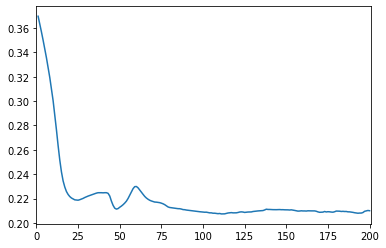

AUC: 0.57
Iteration: 2
 Epoch [181] | Loss: 0.2099 | AdvantageI: -0.0397 | Precision: 0.0096 | Recall: 0.0870 | F1: 0.0173 | AUC: 0.5543 | AUPRC: 0.0000 | TN: 12573 | FP:619 | FN: 63 | TP: 6 | | 

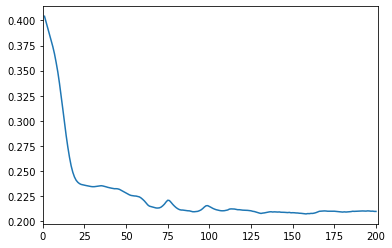

AUC: 0.59
Iteration: 3
 Epoch [181] | Loss: 0.2095 | AdvantageI: -0.0351 | Precision: 0.0120 | Recall: 0.0580 | F1: 0.0200 | AUC: 0.5246 | AUPRC: 0.0000 | TN: 12864 | FP:328 | FN: 65 | TP: 4 | | 

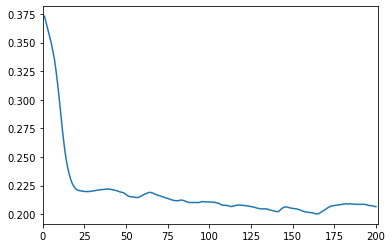

AUC: 0.58
Iteration: 4
 Epoch [181] | Loss: 0.2062 | AdvantageI: -0.0072 | Precision: 0.0010 | Recall: 0.0725 | F1: 0.0020 | AUC: 0.5019 | AUPRC: 0.0000 | TN: 8232 | FP:4960 | FN: 64 | TP: 5 | 

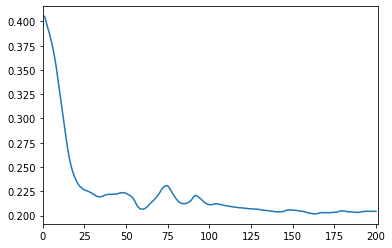

AUC: 0.52
Iteration: 5
 Epoch [181] | Loss: 0.1991 | AdvantageI: -0.0043 | Precision: 0.0028 | Recall: 0.2029 | F1: 0.0056 | AUC: 0.5126 | AUPRC: 0.0000 | TN: 8255 | FP:4937 | FN: 55 | TP: 14 | 

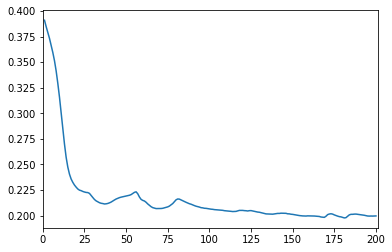

AUC: 0.55
Iteration: 6
 Epoch [181] | Loss: 0.2032 | AdvantageI: -0.0024 | Precision: 0.0019 | Recall: 0.1449 | F1: 0.0037 | AUC: 0.5350 | AUPRC: 0.0000 | TN: 7877 | FP:5315 | FN: 59 | TP: 10 | 

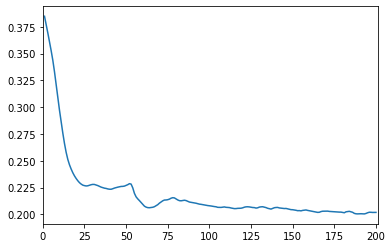

AUC: 0.52
Iteration: 7
 Epoch [181] | Loss: 0.2099 | AdvantageI: -0.0285 | Precision: 0.0024 | Recall: 0.0290 | F1: 0.0045 | AUC: 0.5196 | AUPRC: 0.0000 | TN: 12374 | FP:818 | FN: 67 | TP: 2 |   

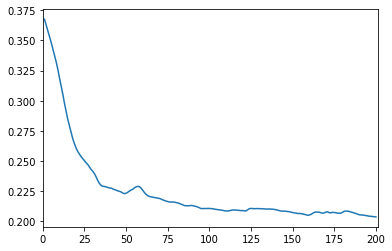

AUC: 0.57
Iteration: 8
 Epoch [181] | Loss: 0.2057 | AdvantageI: 0.0002 | Precision: 0.0023 | Recall: 0.1884 | F1: 0.0046 | AUC: 0.5241 | AUPRC: 0.0000 | TN: 7568 | FP:5624 | FN: 56 | TP: 13 |  

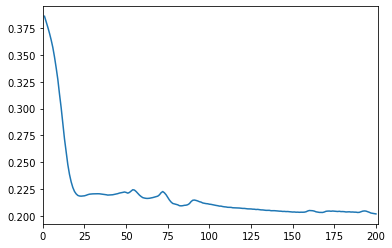

AUC: 0.53
Iteration: 9
 Epoch [181] | Loss: 0.2095 | AdvantageI: -0.0321 | Precision: 0.0035 | Recall: 0.0290 | F1: 0.0062 | AUC: 0.5860 | AUPRC: 0.0000 | TN: 12617 | FP:575 | FN: 67 | TP: 2 |   

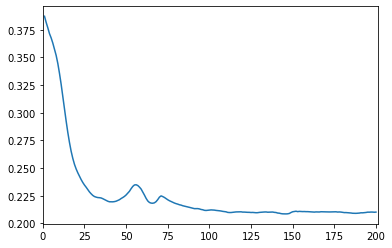

AUC: 0.57
Iteration: 10
 Epoch [181] | Loss: 0.2102 | AdvantageI: -0.0173 | Precision: 0.0082 | Recall: 0.1014 | F1: 0.0151 | AUC: 0.5196 | AUPRC: 0.0000 | TN: 12343 | FP:849 | FN: 62 | TP: 7 | | 

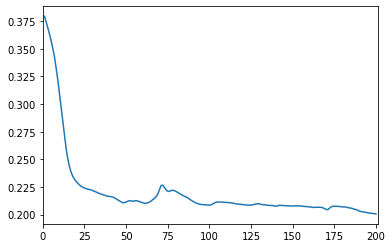

AUC: 0.59
Iteration: 11
 Epoch [181] | Loss: 0.2106 | AdvantageI: -0.0217 | Precision: 0.0013 | Recall: 0.0290 | F1: 0.0025 | AUC: 0.5909 | AUPRC: 0.0000 | TN: 11658 | FP:1534 | FN: 67 | TP: 2 | 

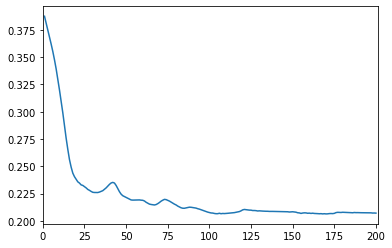

AUC: 0.56
Iteration: 12
 Epoch [181] | Loss: 0.2063 | AdvantageI: -0.0231 | Precision: 0.0097 | Recall: 0.1884 | F1: 0.0184 | AUC: 0.5702 | AUPRC: 0.0000 | TN: 11862 | FP:1330 | FN: 56 | TP: 13 | 

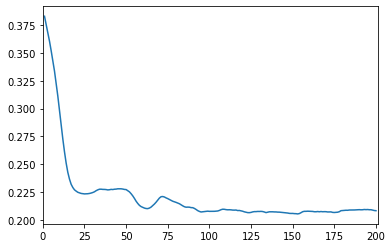

AUC: 0.59
Iteration: 13
 Epoch [181] | Loss: 0.2065 | AdvantageI: -0.0231 | Precision: 0.0122 | Recall: 0.0580 | F1: 0.0201 | AUC: 0.5731 | AUPRC: 0.0000 | TN: 12867 | FP:325 | FN: 65 | TP: 4 | | 

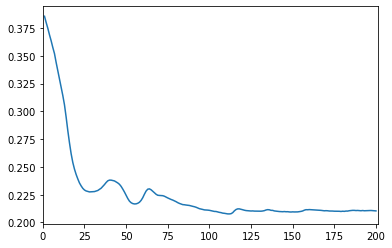

AUC: 0.57
Iteration: 14
 Epoch [181] | Loss: 0.2114 | AdvantageI: -0.0154 | Precision: 0.0005 | Recall: 0.0145 | F1: 0.0010 | AUC: 0.5891 | AUPRC: 0.0000 | TN: 11174 | FP:2018 | FN: 68 | TP: 1 | 

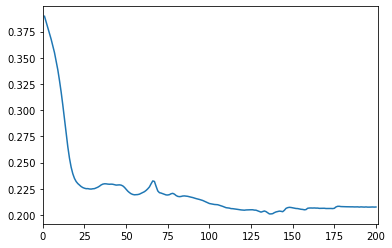

AUC: 0.56
Iteration: 15
 Epoch [181] | Loss: 0.2122 | AdvantageI: -0.0221 | Precision: 0.0152 | Recall: 0.1304 | F1: 0.0271 | AUC: 0.6068 | AUPRC: 0.0000 | TN: 12607 | FP:585 | FN: 60 | TP: 9 | | 

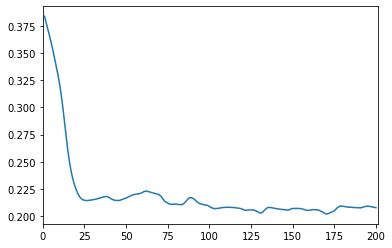

AUC: 0.59
Iteration: 16
 Epoch [181] | Loss: 0.2062 | AdvantageI: -0.0050 | Precision: 0.0038 | Recall: 0.0870 | F1: 0.0073 | AUC: 0.5791 | AUPRC: 0.0000 | TN: 11627 | FP:1565 | FN: 63 | TP: 6 | 

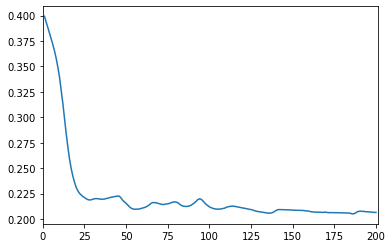

AUC: 0.56
Iteration: 17
 Epoch [181] | Loss: 0.2088 | AdvantageI: -0.0072 | Precision: 0.0020 | Recall: 0.0870 | F1: 0.0039 | AUC: 0.5900 | AUPRC: 0.0000 | TN: 10219 | FP:2973 | FN: 63 | TP: 6 | 

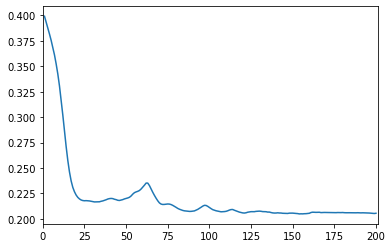

AUC: 0.54
Iteration: 18
 Epoch [181] | Loss: 0.2068 | AdvantageI: -0.0266 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.5447 | AUPRC: 0.0000 | TN: 12232 | FP:960 | FN: 69 | TP: 0 | | 

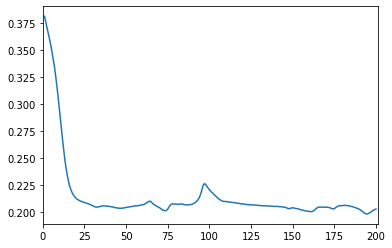

AUC: 0.51
Iteration: 19
 Epoch [181] | Loss: 0.2022 | AdvantageI: -0.0105 | Precision: 0.0087 | Recall: 0.3333 | F1: 0.0169 | AUC: 0.6560 | AUPRC: 0.0000 | TN: 10562 | FP:2630 | FN: 46 | TP: 23 | 

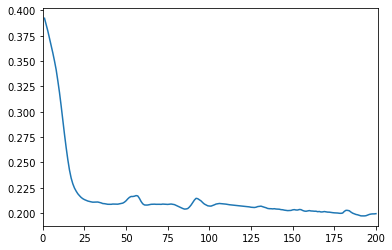

AUC: 0.59
Iteration: 20
 Epoch [181] | Loss: 0.2076 | AdvantageI: -0.0285 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.5975 | AUPRC: 0.0000 | TN: 12523 | FP:669 | FN: 69 | TP: 0 |  

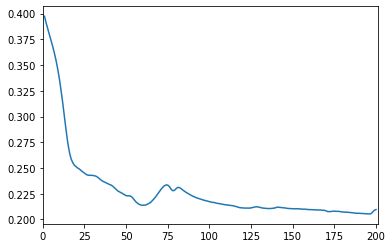

AUC: 0.59


In [13]:
n_runs = 20
auc_list = []
seed = 42

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_Bank(PATH, seed*(i+1), percAnomalies = 0.03, show=False, anoIndex = 1, normIndex = 0)
    params['nc'] = dataset['x_train'].shape[1]
    
    pos_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']).to(device),
                            batch_size=params['bs'], shuffle=True)
    
    unlab_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_unlab']).to(device), 
                              batch_size=params['bs'], shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))

    test_loader = DataLoader(dataset=test_dataset, batch_size=params['bs'], shuffle=False)
    
    trainer = Trainer(params, device)
    values = trainer.train(pos_loader, unlab_loader, dataset, num_epochs)
    auc = trainer.test(test_loader)
    print(f'AUC: {auc:.2f}')
    auc_list.append(auc)

In [14]:
print(auc_list)
print(f'Mean Auc: {np.mean(auc_list):.2f}, std: {np.std(auc_list):.2f}')

WALDO_Bank_3 = pd.DataFrame(auc_list, columns = ['WALDO_Bank_3'])
print(WALDO_Bank_3)

WALDO_Bank_3.to_csv('./WALDO_Bank_3.csv', index=False)

[0.5730591560011956, 0.5867317539680382, 0.5750812553402836, 0.5222916270391202, 0.5516831517259495, 0.5231275040835243, 0.5681138646594748, 0.5293504630007035, 0.5730568538294551, 0.5887143012418141, 0.56075952042366, 0.5856970221219835, 0.5746323318508857, 0.5582394726592574, 0.5855158298838498, 0.5638516767358375, 0.5439244555552536, 0.5103656603534323, 0.5909821668493308, 0.589690082395104]
Mean Auc: 0.56, std: 0.02
    WALDO_Bank_3
0       0.573059
1       0.586732
2       0.575081
3       0.522292
4       0.551683
5       0.523128
6       0.568114
7       0.529350
8       0.573057
9       0.588714
10      0.560760
11      0.585697
12      0.574632
13      0.558239
14      0.585516
15      0.563852
16      0.543924
17      0.510366
18      0.590982
19      0.589690


In [15]:
WALDO_Bank_3 = list(WALDO_Bank_3['WALDO_Bank_3'])

N = len(WALDO_Bank_3)
mean_auc = np.mean(WALDO_Bank_3)
std_auc = np.std(WALDO_Bank_3)
std_error = std_auc / (np.sqrt(N))

ci = 1.96 * std_error
lower_bound = mean_auc - ci
upper_bound = mean_auc + ci

print(f'{mean_auc:.2f} +/- {ci:.2f}')
print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

0.56 +/- 0.01
95% confidence level, average auc would be between 0.55 and 0.57
